# **Major II "An Ensemble of Deep Learning and Vision-based techniques for Road Lane & Vehicle Detection"**

**Divyanshi Bhojak (202IT007)**





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Necessary Import**

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import os.path
from pathlib import Path
import glob
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, SpatialDropout2D
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing import image
from PIL import Image

# **Data Loading**

In [ ]:
# Selecting Dataset Folder Paths
dir_ = Path('/content/drive/MyDrive/MajorProject/VD/data')
filepaths = list(dir_.glob(r'**/*.png'))
# Mapping the labels
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name = 'File').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenating...
df = pd.concat([filepaths, labels], axis=1)

df = df.sample(frac = 1, random_state = 56).reset_index(drop = True)

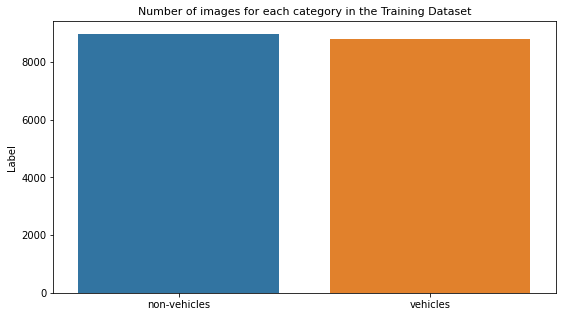

In [ ]:
vc = df['Label'].value_counts()
plt.figure(figsize = (9, 5))
sns.barplot(x = vc.index, y = vc)
plt.title("Number of images for each category in the Training Dataset", fontsize = 11)
plt.show()

Text(0.5, 1.0, 'non-vehicles')

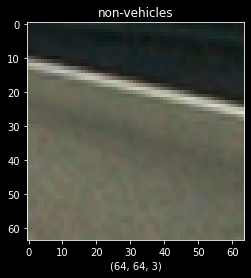

In [ ]:
plt.style.use("dark_background")

figure = plt.figure(figsize=(4,4))
x = plt.imread(df["File"][32])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(df["Label"][32])



Text(0.5, 1.0, 'vehicles')

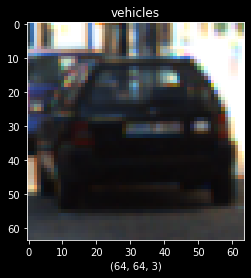

In [ ]:
figure = plt.figure(figsize=(4,4))
x = plt.imread(df["File"][15])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(df["Label"][15])

# Sample vehicles and non-vehicles images from dataset

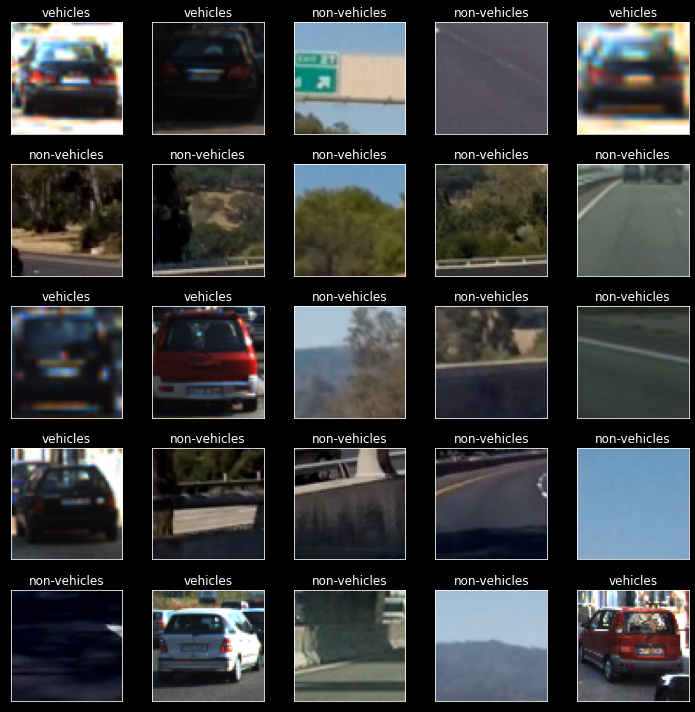

In [ ]:
fig, axes = plt.subplots(nrows = 5,
                        ncols = 5,
                        figsize = (10,10),
                        subplot_kw = {"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df["File"][i]))
    ax.set_title(df["Label"][i])
plt.tight_layout()
plt.show()

In [ ]:
trainset_df, testset_df = train_test_split(df, train_size = 0.80, random_state = 42)

display(trainset_df.head())

testset_df.head()

File         Label
2086   /content/drive/MyDrive/MajorProject/VD/data/ve...      vehicles
13310  /content/drive/MyDrive/MajorProject/VD/data/no...  non-vehicles
373    /content/drive/MyDrive/MajorProject/VD/data/no...  non-vehicles
2182   /content/drive/MyDrive/MajorProject/VD/data/no...  non-vehicles
10481  /content/drive/MyDrive/MajorProject/VD/data/no...  non-vehicles

File         Label
17759  /content/drive/MyDrive/MajorProject/VD/data/no...  non-vehicles
13549  /content/drive/MyDrive/MajorProject/VD/data/ve...      vehicles
16934  /content/drive/MyDrive/MajorProject/VD/data/ve...      vehicles
4105   /content/drive/MyDrive/MajorProject/VD/data/ve...      vehicles
16652  /content/drive/MyDrive/MajorProject/VD/data/ve...      vehicles

# **Dividing dataset into training and testing sets**

In [ ]:
# converting the Label to a numeric format for testing later...
LE = LabelEncoder()

y_test = LE.fit_transform(testset_df["Label"])

# Viewing data in training dataset
print('Training Dataset:')

print(f'Number of images: {trainset_df.shape[0]}')

print(f'Number of images with non-vehicles: {trainset_df["Label"].value_counts()[0]}')
print(f'Number of images with vehicles: {trainset_df["Label"].value_counts()[1]}\n')

# Viewing data in test dataset
print('Test Dataset:')

print(f'Number of images: {testset_df.shape[0]}')

print(f'Number of images with non-vehicles: {testset_df["Label"].value_counts()[0]}')
print(f'Number of images with vehicles: {testset_df["Label"].value_counts()[1]}\n')



Training Dataset:
Number of images: 14228
Number of images with non-vehicles: 7165
Number of images with vehicles: 7063

Test Dataset:
Number of images: 3558
Number of images with non-vehicles: 1809
Number of images with vehicles: 1749



In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    validation_split = 0.1)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
print("Preparing the training dataset ...")
training_set = train_datagen.flow_from_dataframe(
    dataframe = trainset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode = "rgb",
    class_mode = "binary",
    batch_size = 256,
    shuffle = True,
    seed = 2,
    subset = "training")

print("Preparing the validation dataset ...")
validation_set = train_datagen.flow_from_dataframe(
    dataframe = trainset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode ="rgb",
    class_mode = "binary",
    batch_size = 256,
    shuffle = True,
    seed = 2,
    subset = "validation")

print("Preparing the test dataset ...")
test_set = test_datagen.flow_from_dataframe(
    dataframe = testset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode ="rgb",
    class_mode = "binary",
    shuffle = False,
    batch_size = 256)

print('Data generators are ready!')

Preparing the training dataset ...
Found 12806 validated image filenames belonging to 2 classes.
Preparing the validation dataset ...
Found 1422 validated image filenames belonging to 2 classes.
Preparing the test dataset ...
Found 3558 validated image filenames belonging to 2 classes.
Data generators are ready!


# Model Training

In [ ]:
# Callbacks
cb = [EarlyStopping(monitor = 'loss', mode = 'min', patience = 5, restore_best_weights = True)]

In [ ]:

CNN_base_inc = InceptionV3(input_shape = (75, 75, 3), include_top = False, weights = 'imagenet')


87924736/87910968 [==============================] - 2s 0us/step


In [ ]:
for layer in CNN_base_inc.layers:
    layer.trainable = False

In [ ]:


x = layers.Flatten()(CNN_base_inc.output)



In [ ]:
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(1, activation='sigmoid')(x)

CNN_inc = Model(CNN_base_inc.input, x)
CNN_inc.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 37, 37, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 37, 37, 32)   0           ['batch_normalization[0][0]']

In [ ]:
plot_model(CNN_inc, show_layer_names = True , show_shapes = True)

In [ ]:

from tensorflow.keras.optimizers import RMSprop

In [ ]:
# Compilation
CNN_inc.compile(optimizer = RMSprop(lr = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

# Start of counting time
start = dt.datetime.now()

# Training and validation
CNN_inc_history = CNN_inc.fit(training_set, epochs = 50, validation_data = validation_set)

# End of Time Counting
end = dt.datetime.now()
time_CNN_inc = end - start
print ('\nTraining and validation time is: ', time_CNN_inc)

CNN_inc.save_weights('/content/drive/MyDrive/VD/incep.h5')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/50
51/51 [==============================] - 1677s 33s/step - loss: 0.2793 - accuracy: 0.9093 - val_loss: 0.1523 - val_accuracy: 0.9599
Epoch 2/50
51/51 [==============================] - 61s 1s/step - loss: 0.1287 - accuracy: 0.9578 - val_loss: 0.0900 - val_accuracy: 0.9768
Epoch 3/50
51/51 [==============================] - 71s 1s/step - loss: 0.1021 - accuracy: 0.9675 - val_loss: 0.0803 - val_accuracy: 0.9691
Epoch 4/50
51/51 [==============================] - 61s 1s/step - loss: 0.0925 - accuracy: 0.9690 - val_loss: 0.0833 - val_accuracy: 0.9684
Epoch 5/50
51/51 [==============================] - 63s 1s/step - loss: 0.0809 - accuracy: 0.9717 - val_loss: 0.0712 - val_accuracy: 0.9761
Epoch 6/50
51/51 [==============================] - 60s 1s/step - loss: 0.0813 - accuracy: 0.9714 - val_loss: 0.0706 - val_accuracy: 0.9747
Epoch 7/50
51/51 [==============================] - 60s 1s/step - loss: 0.0729 - accuracy: 0.9748 - val_loss: 0.0637 - val_accuracy: 0.9733
Epoch 8/50
51/51 

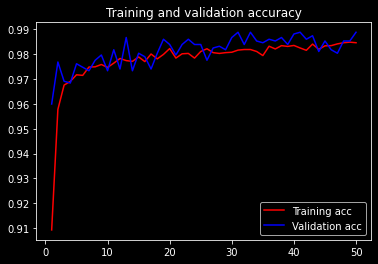

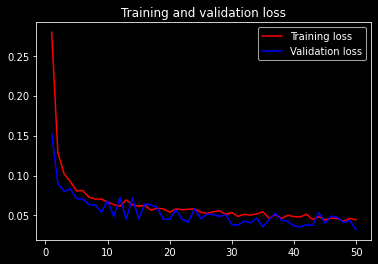

In [ ]:
acc = CNN_inc_history.history['accuracy']
val_acc = CNN_inc_history.history['val_accuracy']
loss = CNN_inc_history.history['loss']
val_loss = CNN_inc_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [ ]:
score_mn = CNN_inc.evaluate(test_set)
print("Test Loss:", score_mn[0])
print("Test Accuracy:", score_mn[1])

14/14 [==============================] - 382s 29s/step - loss: 0.0282 - accuracy: 0.9890
Test Loss: 0.02816772274672985
Test Accuracy: 0.9890387654304504


In [ ]:
y_pred_mn = CNN_inc.predict(test_set)
y_pred_mn = np.round(y_pred_mn)

recall_mn = recall_score(y_test, y_pred_mn)
precision_mn = precision_score(y_test, y_pred_mn)
f1_mn = f1_score(y_test, y_pred_mn)
roc_mn = roc_auc_score(y_test, y_pred_mn)

print(classification_report(y_test, y_pred_mn))



              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1809
           1       0.99      0.99      0.99      1749

    accuracy                           0.99      3558
   macro avg       0.99      0.99      0.99      3558
weighted avg       0.99      0.99      0.99      3558



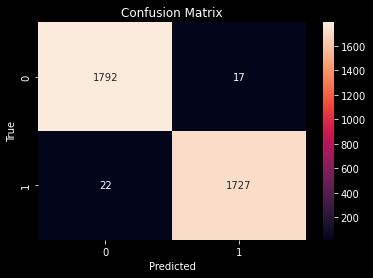

In [ ]:
plt.figure(figsize = (6, 4))

sns.heatmap(confusion_matrix(y_test, y_pred_mn),annot = True, fmt = 'd')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

In [ ]:
y_pred_inc = CNN_inc.predict(test_set)
y_pred_inc = np.round(y_pred_inc)

recall_inc = recall_score(y_test, y_pred_inc)
precision_inc = precision_score(y_test, y_pred_inc)
f1_inc = f1_score(y_test, y_pred_inc)
roc_inc = roc_auc_score(y_test, y_pred_inc)

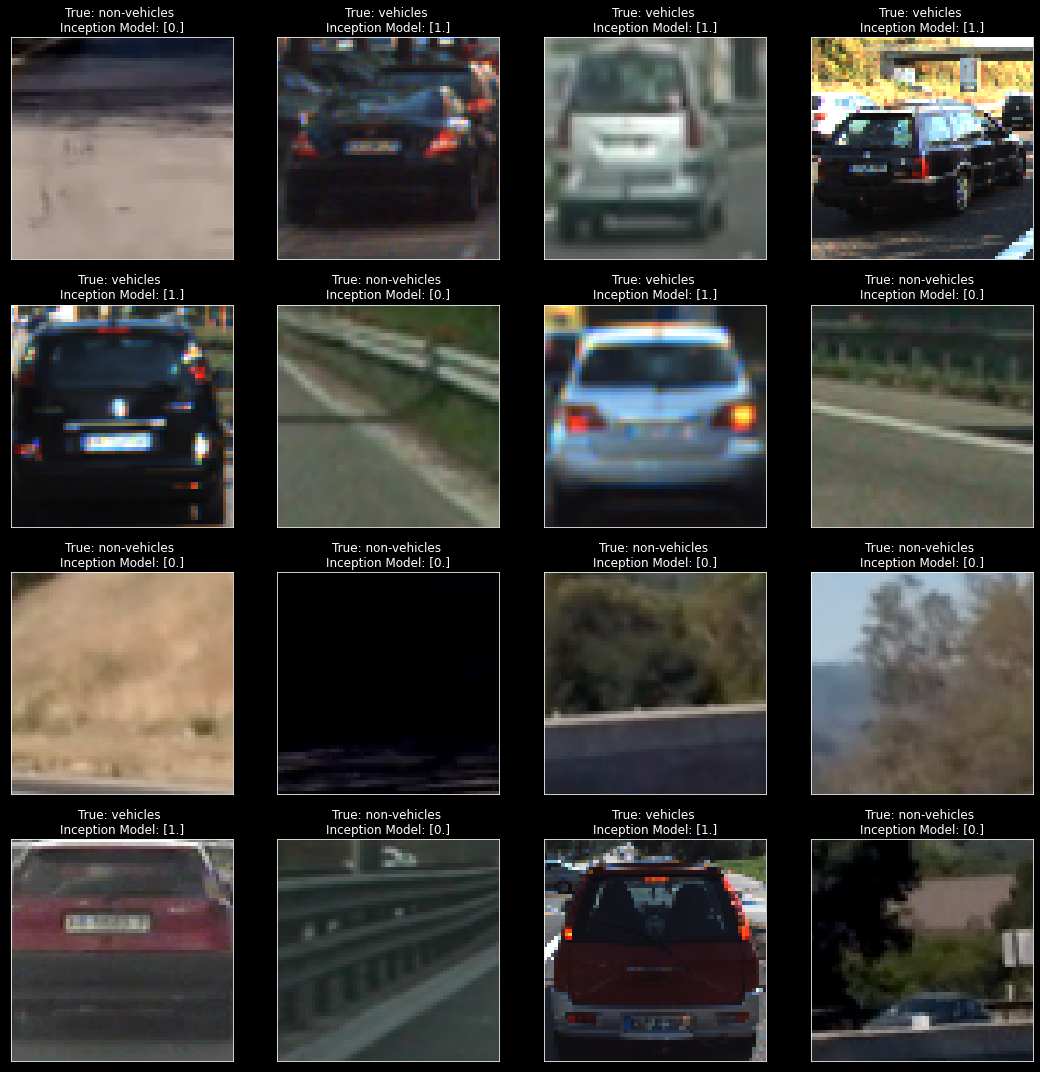

In [ ]:
plt.style.use("dark_background")


fig, axes = plt.subplots(nrows = 4,
                         ncols = 4,
                         figsize = (15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(testset_df["File"].iloc[i]))
    ax.set_title(f"True: {testset_df.Label.iloc[i]} \nInception Model: {y_pred_mn[i]}")
plt.tight_layout()
plt.show()

# **Integrating Vision-based Techniques**







Using earlier trained neural network models searching for vehicles

In [ ]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

def search_vehicles(img):
    # We crop the image to 440-660px in the vertical direction
    cropped = img[400:660, 0:1280]
    heat = heatmodel.predict(cropped.reshape(1,cropped.shape[0],cropped.shape[1],cropped.shape[2]))
    # This finds us rectangles that are interesting
    xx, yy = np.meshgrid(np.arange(heat.shape[2]),np.arange(heat.shape[1]))
    x = (xx[heat[0,:,:,0]>0.9999999])
    y = (yy[heat[0,:,:,0]>0.9999999])
    hot_windows = []
    # We save those rects in a list
    for i,j in zip(x,y):
        hot_windows.append(((i*8,400 + j*8), (i*8+64,400 +j*8+64)))
    return hot_windows

# Init a version of our network with another resolution without the flatten layer
heatmodel = create_model((260, 1280, 3))
# Load the weights
heatmodel.load_weights('/content/drive/MyDrive/VD/incep.h5')

# Search for our windows
hot_windows = search_vehicles(img)

# Draw the found boxes on the  image
window_img = draw_boxes(img, hot_windows, (0, 255, 0), 6)                    

# Show the image with the windows on top
fig = plt.figure(figsize=(12,20))
plt.imshow(window_img)

In [ ]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected vehicles
    for vehiclenumber in range(1, labels[1]+1):
        # Find pixels with each vehiclenumber label value
        nonzero = (labels[0] == vehiclenumber).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image
    return img


# Add heat to each box in box list
heat = add_heat(heat,hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 3)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
boxes = label(heatmap)

# Create the final image
draw_img = draw_labeled_bboxes(np.copy(img), boxes)


#  Pipeline identifies the area inside two lanes and drawing green between them

In [ ]:
# Define the source points
src_points = np.float32([[0 , 720],
                         [1280 , 720],
                         [750 , 470],
                         [530 , 470]])

# Define the destination points
dst_points = np.float32([[320 , 720],
                         [960 , 720],
                         [960 , 0],
                         [320 , 0]])
# Storing our averages
prev_frames = []
prev_curvatures = []
prev_Vehicle_off = []

def region_of_interest(img,vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def applyTransformation(img):
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src_points, dst_points)

    # Warp the image using OpenCV warpPerspective()
    transformed = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    
    # Return transformed image
    return transformed

def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def mag_thresh(img, thresh_min=0, thresh_max=255):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=9)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=9)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh_min) & (gradmag <= thresh_max)] = 1

    # Return the binary image
    return binary_output

def applySobelMask(img):
    # Convert to HLS and extract L and S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Apply sobel in x direction on L and S channel
    l_channel_sobel_x = abs_sobel_thresh(l_channel,'x', 20, 200)
    s_channel_sobel_x = abs_sobel_thresh(s_channel,'x', 60, 200)
    sobel_combined_x = cv2.bitwise_or(s_channel_sobel_x, l_channel_sobel_x)
    
    # Apply magnitude sobel
    l_channel_mag = mag_thresh(l_channel, 80, 200)
    s_channel_mag = mag_thresh(s_channel, 80, 200)
    mag_combined = cv2.bitwise_or(l_channel_mag, s_channel_mag)
    
    # Combine all the sobel filters
    mask_combined = cv2.bitwise_or(mag_combined, sobel_combined_x)
    
    # Mask out the desired image and filter image again
    mask_combined = region_of_interest(mask_combined, np.array([[(330, 0),(950, 0), (950, 680), (330, 680)]]))
    
    # Return the sobel mask
    return mask_combined

def applyColorMask(img):
    # Convert to HLS and extract S and V channel
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Define color thresholds in HSV
    white_low = np.array([[[0, 0, 210]]])
    white_high = np.array([[[255, 30, 255]]])

    yellow_low = np.array([[[18, 80, 80]]])
    yellow_high = np.array([[[30, 255, 255]]])

    # Apply the thresholds to get only white and yellow
    white_mask = cv2.inRange(img_hsv, white_low, white_high)
    yellow_mask = cv2.inRange(img_hsv, yellow_low, yellow_high)

    # Bitwise or the yellow and white mask
    color_mask = cv2.bitwise_or(yellow_mask, white_mask)
    return color_mask

def combineMasks(sobel_mask, color_mask):
    mask_combined = np.zeros_like(sobel_mask)
    mask_combined[(color_mask>=.5)|(sobel_mask>=.5)] = 1
    return mask_combined

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def slidingWindow(img):
    # Window settings
    window_width = 50
    window_height = 100
    # How much to slide left and right for searching
    margin = 30
    
    # Store the (left,right) window centroid positions per level
    window_centroids = [] 
    # Create our window template that we will use for convolutions
    window = np.ones(window_width) 
    
    # Find the starting point for the lines
    l_sum = np.sum(img[int(3*img.shape[0]/5):,:int(img.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(img[int(3*img.shape[0]/5):,int(img.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(img.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1, (int)(img.shape[0] / window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(img[int(img.shape[0]-(level+1)*window_height):int(img.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width / 2
        # Find the best left centroid by using past left center as a reference
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,img.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,img.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
    
    # If we have found any window centers, print error and return
    if len(window_centroids) == 0:
        print("No windows found in this frame!")
        return
    
    # Points used to draw all the left and right windows
    l_points = np.zeros_like(img)
    r_points = np.zeros_like(img)

    # Go through each level and draw the windows
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,img,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,img,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((template, template, template)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((img, img, img)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
    
    # Extract left and right line pixel positions
    leftx = np.nonzero(l_points)[1]
    lefty = np.nonzero(l_points)[0]
    rightx = np.nonzero(r_points)[1]
    righty = np.nonzero(r_points)[0]
            
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Return left and right lines as well as the image
    return left_fit, right_fit, output

def calcCurvature(left_fit, right_fit):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ploty = np.linspace(0, 719, num=720)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Set y-value to bottom of the image
    y_eval = 719
    # Calculate left and right curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Match them together
    curverad = (left_curverad + right_curverad) / 2
    
    # Use the last ten values and build the average of them
    prev_curvatures.append(curverad)
    avg_curverad = np.average(prev_curvatures[-10:])
    
    # Return the average curvature in meter
    return avg_curverad

def calcVehicleOff(left_fit, right_fit):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Left and right line intercept on x axis
    left_intcpt = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    right_intcpt = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]

    # Calculate the middle of the lanes
    lane_mid = (left_intcpt + right_intcpt)/2.0

    # Calculate the offset
    vehicle_off = (lane_mid - 1280/2.0)*xm_per_pix
    
    # Average over the last ten positions
    prev_vehicle_off.append(vehicle_off)
    avg_vehicle_off = np.average(prev_vehicle_off[-10:])
    
    return avg_vehicle_off

def displayInfo(img, curverad, vehicle_off):
    font = cv2.FONT_HERSHEY_COMPLEX_SMALL
    curve_disp_txt = 'Curvature: ' + str(np.round(curverad,2)) + 'm'
    off_disp_txt = 'Vehicle offset: ' + str(np.round(Vehicle_off,2)) + 'm'
    cv2.putText(img, curve_disp_txt, (20, 30), font, 1, (0,0,0), 2)
    cv2.putText(img, off_disp_txt, (20, 60), font, 1, (0,0,0), 2)
    return img

def applyBackTrans(img, left_fit, right_fit):
    ploty = np.linspace(0, 719, num=720)
    # Calculate left and right x positions
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Defining a blank mask to start with
    polygon = np.zeros_like(img) 

    # Create an array of points for the polygon
    plot_y = np.linspace(0, img.shape[0]-1, img.shape[0])
    pts_left = np.array([np.transpose(np.vstack([left_fitx, plot_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, plot_y])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the polygon 
    cv2.fillPoly(polygon, np.int_([pts]), (0, 0, 255))
    
    # Calculate top and bottom distance between the lanes
    top_dist = right_fitx[0] - left_fitx[0]
    bottom_dist = right_fitx[-1] - left_fitx[-1]
    
    # Add the polygon to the list of last frames if it makes sense
    if len(prev_frames) > 0: 
        if top_dist < 300 or bottom_dist < 300 or top_dist > 500 or bottom_dist > 500:
            polygon = prev_frames[-1]
        else:
            prev_frames.append(polygon)
    else:
        prev_frames.append(polygon)
        
    # Check that the new detected lane is similar to the one detected in the previous frame
    polygon_gray = cv2.cvtColor(polygon, cv2.COLOR_RGB2GRAY) 
    prev_gray = cv2.cvtColor(prev_frames[-1], cv2.COLOR_RGB2GRAY)  
    non_similarity = cv2.matchShapes(polygon_gray,prev_gray, 1, 0.0)
    if non_similarity > 0.002: 
        polygon = prev_frames[-1]

    # Calculate the inverse transformation matrix
    M_inv = cv2.getPerspectiveTransform(dst_points, src_points)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    image_backtrans = cv2.warpPerspective(polygon, M_inv, (img.shape[1], img.shape[0])) 
    
    # Return the 8-bit mask
    return np.uint8(image_backtrans)

def findLanes(img):   
    # Copy and crop the image
    img_cropped = np.copy(img)
    img_cropped = region_of_interest(img_cropped, [src_points.astype(np.int32)])
    
    # Apply image transformation
    img_warped = applyTransformation(img_cropped)
    
    # Apply the sobel mask to the image
    img_sobel = applySobelMask(img_warped)
    
    # Apply the color mask to the image
    img_color = applyColorMask(img_warped)
    
    # Combine color and sobel mask
    img_mask = combineMasks(img_sobel, img_color)
    
    # Find the lines from polyfit
    left_fit, right_fit, _ = slidingWindow(img_mask)
    
    # Create the lane mask and apply backtransformation
    lane_mask = applyBackTrans(img, left_fit, right_fit)
    
    # Combine the sample image with the lane layer
    img_result = cv2.addWeighted(img, 1, lane_mask, 1, 0)
    
    # Add the information for the image
    curverad = calcCurvature(left_fit, right_fit)
    Vehicle_off = calcVehicleOff(left_fit, right_fit)
    img_info = displayInfo(img_result, curverad, Vehicle_off)
    return img_info



# Final pipeline for video processing

In [ ]:
# Create history element
history = None

# Our video processing pipeline
def process_video(img):
    # Find the lane lines first
    img_lanes = findLanes(img)
    
    # Create image for the heat similar to one shown above 
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Find the Vehicles
    hot_windows = search_vehicles(img)

    # Create image for the heat similar to one shown above 
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,3)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    boxes = label(heatmap)
    
    # Iterate through all detected Vehicles
    for Vehicle_number in range(1, boxes[1]+1):
        # Find pixels with each Vehicle_number label value
        nonzero = (boxes[0] == Vehicle_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Append current boxe to history
        history.append([np.min(nonzerox),np.min(nonzeroy),np.max(nonzerox),np.max(nonzeroy)])
    
    # Get recent boxes for the last 30 fps
    recent_boxes = np.array(history).tolist()

    # Groups the object candidate rectangles with difference of 10%
    boxes = cv2.groupRectangles(recent_boxes, 10, .1)
    
    # Draw rectangles if found
    if len(boxes[0]) != 0:
        for box in boxes[0]:
            cv2.rectangle(img_lanes, (box[0], box[1]), (box[2],box[3]), (0,255,0), 6)
            
    # Return image with found Vehicles and lanes
    return img_lanes

In [ ]:
from moviepy.editor import VideoFileClip

lane_Vehicle_detection = LaneVehicleDetection(process_video,png=False)

project_output = '/content/drive/MyDrive/L+V-v1.mp4'

clip1 = VideoFileClip("/content/drive/MyDrive/MajorProject/Videos/v1.mp4")
out_clip = clip1.fl_image(lane_Vehicle_detection.find_lane_lines_and_Vehicles) 

%time out_clip.write_videofile(project_output, audio=False)

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)4104192/45929032 bytes (8.9%)8216576/45929032 bytes (17.9%)12337152/45929032 bytes (26.9%)16113664/45929032 bytes (35.1%)20201472/45929032 bytes (44.0%)24281088/45929032 bytes (52.9%)28352512/45929032 bytes (61.7%)32448512/45929032 bytes (70.6%)36519936/45929032 bytes (79.5%)40607744/45929032 bytes (88.4%)44679168/45929032 bytes (97.3%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

100%|██████████| 485/485 [07:43<00:00,  1.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/L+V-v1.mp4 

CPU times: user 7min 59s, sys: 2min 28s, total: 10min 28s
Wall time: 7min 45s
